# ShareGPT4V - LoRA Fine-tuning

1. Set up the required libraries
2. Prepare the model and dataset
3. Configure LoRA
4. Fine-tune the model
5. Save the LoRA weights
6. Test the fine-tuned model

## 1. Setup and Requirements

In [1]:
import os
import torch
from peft import LoraConfig, get_peft_model, PeftModel

from share4v.model import Share4VLlamaForCausalLM
from share4v.constants import DEFAULT_IMAGE_TOKEN
from share4v.mm_utils import tokenizer_image_token
from share4v.model.builder import load_pretrained_model

from share4v.train.train import get_peft_state_maybe_zero_3, get_peft_state_non_lora_maybe_zero_3

# Set up basic configurations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/jupyter/.cache/pypoetry/virtualenvs/share4v-KfdsAbnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jupyter/.cache/pypoetry/virtualenvs/share4v-KfdsAbnj-py3.10/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/home/jupyter/.cache/pypoetry/virtualenvs/share4v-KfdsAbnj-py3.10/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
Using device: cpu


## 2. Load Base Model

In [2]:
model_path = "Lin-Chen/ShareGPT4V-7B"
model_name = "share4v-7b"

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path, None, model_name, False, False
)

share4v-7b
{'device_map': 'auto', 'torch_dtype': torch.float32}






/home/jupyter/.cache/pypoetry/virtualenvs/share4v-KfdsAbnj-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:18<00:00,  9.08s/it]


Load vision tower from Lin-Chen/ShareGPT4V-7B_Pretrained_vit-large336-l12


In [3]:
model = model.requires_grad_(False)

## 3. Prepare Dataset

In [4]:
from share4v.train.train import (
    LazySupervisedDataset, 
    DataArguments, 
    DataCollatorForSupervisedDataset
)
data_args = DataArguments(
    data_path="../data/example_training.json",
    lazy_preprocess=False, # Typically TRUE
    is_multimodal=True,
    image_folder="../data",
    image_aspect_ratio="square"
)
data_args.image_processor = image_processor
data_args.mm_use_im_start_end = False

In [5]:
dataset = LazySupervisedDataset(
    data_path=data_args.data_path,
    tokenizer=tokenizer,
    data_args=data_args
)
print(f"Dataset created with {len(dataset)} examples")

Dataset created with 2 examples


example

In [6]:
example = dataset[0]
print("\nExample data:")
print("-" * 50)
print(f"Keys in example: {list(example.keys())}")
if "input_ids" in example:
    print(f"Input IDs shape: {example['input_ids'].shape}")
if "labels" in example:
    print(f"Labels shape: {example['labels'].shape}")
if "image" in example:
    print(f"Image tensor shape: {example['image'].shape}")
print("-" * 50)


Example data:
--------------------------------------------------
Keys in example: ['input_ids', 'labels', 'image']
Input IDs shape: torch.Size([131])
Labels shape: torch.Size([131])
Image tensor shape: torch.Size([3, 336, 336])
--------------------------------------------------


In [7]:
for i in example['input_ids']:
    try:
        print(tokenizer.decode(i), end=" ")
    except:
        print()
        print("Error decoding token:", i)

<s> A chat between a curious user and an artificial intelligence assistant . The assistant gives helpful , detailed , and pol ite answers to the user ' s questions . US ER :  
Error decoding token: tensor(-200)
 <0x0A> What ' s happening in this image ? A SS IST ANT : This image shows Walter White and J esse P ink man from the TV series Bre aking Bad . They appear to be in their mobile m eth lab , we aring protect ive yellow ha z mat su its , which is an icon ic scene from the show . The two characters are likely engaged in cook ing m eth am ph et am ine , which is the central activity dep icted throughout the series . </s> 

In [8]:
# Use the original DataCollatorForSupervisedDataset from train.py
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

## 4. Configure LoRA

In [9]:
# Select the linear layers for LoRA
# Copyed from train.py

def find_all_linear_names(model):
    """
    Find all linear layer names in the model that are suitable for LoRA.
    Excludes multimodal components (vision tower, mm_projector, etc.)
    """
    cls = torch.nn.Linear
    lora_module_names = set()
    multimodal_keywords = ['mm_projector', 'vision_tower', 'vision_resampler']
    
    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in multimodal_keywords):
            continue
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    
    return list(lora_module_names)

In [10]:
def prepare_model_for_lora(
    model, 
    lora_r=64,            # LoRA rank - lower means fewer parameters, higher means more capacity
    lora_alpha=16,        # LoRA alpha - scaling factor (usually 2x to 4x of rank)
    lora_dropout=0.05,    # LoRA dropout - regularization to prevent overfitting
    bias="none",          # Whether to train bias parameters ("none", "all", or "lora_only")
    target_modules=None,  # Which modules to apply LoRA to. If None, will find all linear layers
    task_type="CAUSAL_LM" # Task type for LoRA configuration
):
    if target_modules is None:
        target_modules = find_all_linear_names(model)

    lora_config = LoraConfig(
        r=lora_r,
        lora_alpha=lora_alpha, 
        target_modules=target_modules,
        lora_dropout=lora_dropout, 
        bias=bias,
        task_type=task_type,
    )
    peft_model = get_peft_model(model, lora_config)
    
    return peft_model

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}%"
    )
    return trainable_params, all_param

In [11]:
target_modules = find_all_linear_names(model)

In [12]:
target_modules

['q_proj', 'down_proj', 'gate_proj', 'o_proj', 'v_proj', 'k_proj', 'up_proj']

In [27]:
import gc
import copy

# Store results for comparison
config_results = []

model_config1 = copy.deepcopy(model)
model_config1 = prepare_model_for_lora(model_config1, lora_r=64, lora_alpha=16)

trainable1, total1 = print_trainable_parameters(model_config1)
del model_config1
config_results.append({"name": "Default (r=64, alpha=16)", "trainable": trainable1, "total": total1})

model_config2 = copy.deepcopy(model)
model_config2 = prepare_model_for_lora(model_config2, lora_r=16, lora_alpha=32)
trainable2, total2 = print_trainable_parameters(model_config2)
del model_config2
config_results.append({"name": "Low rank (r=16, alpha=32)", "trainable": trainable2, "total": total2})

target_modules = ["q_proj", "v_proj"]  # Only attention query and value projections
model_config3 = copy.deepcopy(model)
model_config3 = prepare_model_for_lora(model_config3, lora_r=64, lora_alpha=16, target_modules=target_modules)
trainable3, total3 = print_trainable_parameters(model_config3)
del model_config3
config_results.append({"name": "Attention only (r=64, alpha=16)", "trainable": trainable3, "total": total3})

model_config4 = copy.deepcopy(model)
model_config4 = prepare_model_for_lora(model_config4, lora_r=16, lora_alpha=16, target_modules=target_modules)
trainable4, total4 = print_trainable_parameters(model_config4)
del model_config4
config_results.append({"name": "Attention only (r=16, alpha=16)", "trainable": trainable4, "total": total4})

trainable params: 42336256 || all params: 7105239040 || trainable%: 0.60%
trainable params: 39845888 || all params: 7102748672 || trainable%: 0.56%
trainable params: 9961472 || all params: 7072864256 || trainable%: 0.14%


In [28]:
# Print comparison table
print("## Configuration Comparison ##")
print("----------------------------------------")
print(f"{'Configuration':<40} {'Trainable':<12} {'% of Model':<12}")
print("----------------------------------------")
for config in config_results:
    print(f"{config['name']:<40} {config['trainable']:<12,d} {(config['trainable']/config['total']*100):.4f}%")

## Configuration Comparison ##
----------------------------------------
Configuration                            Trainable    % of Model  
----------------------------------------
Default (r=64, alpha=16)                 169,345,024  2.3415%
Low rank (r=16, alpha=32)                42,336,256   0.5958%
Attention only (r=64, alpha=16)          39,845,888   0.5610%
Attention only (r=16, alpha=16)          9,961,472    0.1408%


## 5. Training Setup

In [13]:
# select model from config 4
target_modules = ["q_proj", "v_proj"]
model = prepare_model_for_lora(model, lora_r=16, lora_alpha=16, target_modules=target_modules)

In [14]:
from share4v.train.share4v_trainer import Share4VTrainer
from share4v.train.train import TrainingArguments

In [15]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./lora_share4v_output",  # Output directory
    num_train_epochs=1,                  # Number of training epochs
    # per_device_train_batch_size=4,       # Batch size per device
    gradient_accumulation_steps=4,       # Number of update steps to accumulate gradients for
    learning_rate=2e-5,                  # Learning rate
    weight_decay=0.01,                   # Weight decay
    save_steps=5,                      # Save every 500 steps
    save_total_limit=3,                  # Keep only the 3 most recent checkpoints
    report_to=None,                      # Disable reporting to wandb etc.
    remove_unused_columns=False,         # Keep all columns
    log_level="info",                    # Logging level
    logging_steps=10,                    # Log every 10 steps
    # fp16=True,                           # Use mixed precision
    lora_enable=True,                    # Enable LoRA training
    group_by_modality_length=False       # Don't group by modality length
)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [17]:
# This is a fix for: model has strange 'hf_device_map' property after lora

# model.hf_device_map
# [device for device in set(model.hf_device_map.values()) if device not in ["cpu", "disk"]]
model.hf_device_map = None

In [18]:
trainer = Share4VTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=dataset,
    data_collator=data_collator,
)

In [19]:
trainer.is_model_parallel

False

## 6. Train

Now we'll start the training process and save the LoRA weights after training.

In [20]:
print("Starting training...")
trainer.train()
print("Training completed!")

***** Running training *****
  Num examples = 2
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 1
  Number of trainable parameters = 9,961,472


Starting training...


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




Training completed!


In [24]:
# Quick install for no notebook restarting sr
# !pip install deepspeed

  Using cached deepspeed-0.16.7-py3-none-any.whl
  Using cached hjson-3.1.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached ninja-1.11.1.4-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.0 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
Using cached hjson-3.1.0-py3-none-any.whl (54 kB)
Using cached ninja-1.11.1.4-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (422 kB)
Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
    torch (>=2.0.1+cpu,<3.0.0)
           ~~~~~~~^

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [21]:
# Save LoRA weights
output_dir = "share4v_lora_weights"
os.makedirs(output_dir, exist_ok=True)

In [26]:
# Extract and save LoRA state dict
lora_state_dict = get_peft_state_maybe_zero_3(
    model.named_parameters(), bias="none"
)

In [28]:
type(lora_state_dict)

dict

In [31]:
lora_state_dict["base_model.model.model.layers.26.self_attn.v_proj.lora_A.default.weight"].shape

torch.Size([16, 4096])

In [32]:
lora_state_dict["base_model.model.model.layers.26.self_attn.v_proj.lora_B.default.weight"].shape

torch.Size([4096, 16])

In [33]:
# Extract non-LoRA trainable weights (like special token embeddings)
non_lora_state_dict = get_peft_state_non_lora_maybe_zero_3(
    model.named_parameters()
)

In [34]:
# Save the model configuration and weights
model.config.save_pretrained(output_dir)
model.save_pretrained(output_dir, state_dict=lora_state_dict)
torch.save(non_lora_state_dict, os.path.join(output_dir, 'non_lora_trainables.bin'))

print(f"LoRA weights saved to {output_dir}")

Configuration saved in share4v_lora_weights/config.json


LoRA weights saved to share4v_lora_weights


# Load model

In [1]:
import os
import torch
from peft import PeftModel

from share4v.model import Share4VLlamaForCausalLM
from share4v.model.builder import load_pretrained_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "Lin-Chen/ShareGPT4V-7B"
model_name = "share4v-7b"

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path, None, model_name, False, False
)
model = model.to(device)

/home/jupyter/.cache/pypoetry/virtualenvs/share4v-KfdsAbnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jupyter/.cache/pypoetry/virtualenvs/share4v-KfdsAbnj-py3.10/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/home/jupyter/.cache/pypoetry/virtualenvs/share4v-KfdsAbnj-py3.10/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
[2025-05-23 10:41:29,843] [WARNING] [real_accelerator.py:194:get_accelerator] Setting accelerator to CPU. If you have GPU or other accelerator, we were unable to detect it.
[2025-05-23 10:41:29,845] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cpu (auto detect)


/opt/conda/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


share4v-7b
{'device_map': 'auto', 'torch_dtype': torch.float32}






/home/jupyter/.cache/pypoetry/virtualenvs/share4v-KfdsAbnj-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:23<00:00, 11.63s/it]


Load vision tower from Lin-Chen/ShareGPT4V-7B_Pretrained_vit-large336-l12


In [2]:
model

Share4VLlamaForCausalLM(
  (model): Share4VLlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (nor

In [4]:
# lora_path = "./share4v_lora_weights" # test weights
lora_path = "./llava-share4v-lora" # A. finetuned

model = PeftModel.from_pretrained(model, lora_path)

In [5]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Share4VLlamaForCausalLM(
      (model): Share4VLlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear(
                in_features=4096, out_features=4096, bia

In [6]:
model = model.merge_and_unload()
model = model.eval()
# model.to(torch.float16)

## Predict

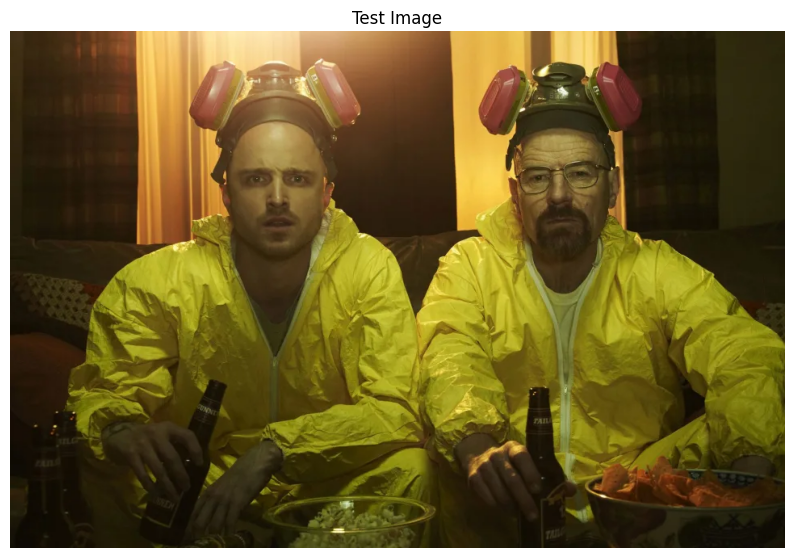

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
from share4v.mm_utils import process_images

image_path = "../examples/breaking_bad.png"
image = Image.open(image_path).convert("RGB")

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.title("Test Image")
plt.show()

images = [image]
images_tensor = process_images(images, image_processor, model.config)
images_tensor = images_tensor.to(device, dtype=torch.float32)

In [26]:
from share4v.constants import IMAGE_TOKEN_INDEX
from share4v.mm_utils import tokenizer_image_token

prompt = "A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.\n\n### USER: Produce a logically connected paragraph of formal analysis that confines its scope to the visual features, excluding all other elements.\n<image>\n### ASSISTANT"
input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt')

input_ids = input_ids.to(device)
print(f"Input shape: {input_ids.shape}")
print(f"Prompt: {prompt}")

Input shape: torch.Size([74])
Prompt: A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.

### USER: Produce a logically connected paragraph of formal analysis that confines its scope to the visual features, excluding all other elements.
<image>
### ASSISTANT


In [27]:
from transformers import TextIteratorStreamer
from threading import Thread

# Generation parameters
temperature = 0.1    # Higher values make output more random/creative
top_p = 0.9          # Nucleus sampling parameter (higher = more diversity)
max_new_tokens = 100  # Maximum number of tokens to generate

# Create a streamer for generating text progressively
streamer = TextIteratorStreamer(
    tokenizer,
    skip_prompt=True,      # Don't include the prompt in the output
    skip_special_tokens=True,  # Don't include special tokens in the output
    timeout=200,           # Timeout in seconds
)

# Generate text using the model
print("Generating response...")
print("-" * 50)

with torch.inference_mode():  # Disables gradient computation for inference
    # Start generation in a separate thread
    thread = Thread(
        target=model.generate,
        kwargs=dict(
            input_ids=input_ids.unsqueeze(0).to(model.device),
            do_sample=True,           # Use sampling instead of greedy decoding
            temperature=temperature,
            top_p=top_p,
            max_new_tokens=max_new_tokens,
            streamer=streamer,
            use_cache=True,           # Use KV cache for faster generation
            images=images_tensor,     # Include the image tensor
        )
    )
    thread.start()

    # Collect generated text from the streamer
    print("Generated text:")
    generated_text = ""
    for new_text in streamer:
        generated_text += new_text
        # Stop if we encounter the stop string
        if generated_text.endswith(stop_str):
            generated_text = generated_text[:-len(stop_str)]
            print("stop string encountered")
            break
        print(new_text, end="")
    print()

Generating response...
--------------------------------------------------
Generated text:
Du valdys scenos vaizduojama kaip atskleidžiantys kuklių kuklų ateliškumas. Dviejų figūrų, kurie pavaizduotai su ryškiais spalvų ir tekstūromis, kūno forma ir kūno apdangai sudaro įvairias formas, kurios atrodo, kurios


In [29]:
thread.join()
del thread